In [30]:
!pip install --upgrade pandas-datareader

!pip install pandas-datareader

In [31]:
!pip install yfinance

# Reading data

Pandas datareader provides a function get_data_yahoo to directly fetch the stock data of the specified stock from Yahoo Finance for the given duration. WE are extracting the Netflix stock price between the duration from till today.

In [32]:
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
yf.pdr_override()
from datetime import datetime

In [33]:
df_netflix = pdr.get_data_yahoo('NFLX', datetime(1970, 1, 1))
df_netflix

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200
...,...,...,...,...,...,...
2023-03-24,320.630005,331.829987,320.630005,328.390015,328.390015,12991700
2023-03-27,327.549988,336.440002,324.410004,327.660004,327.660004,8625800
2023-03-28,326.059998,333.320007,321.279999,323.519989,323.519989,6489400


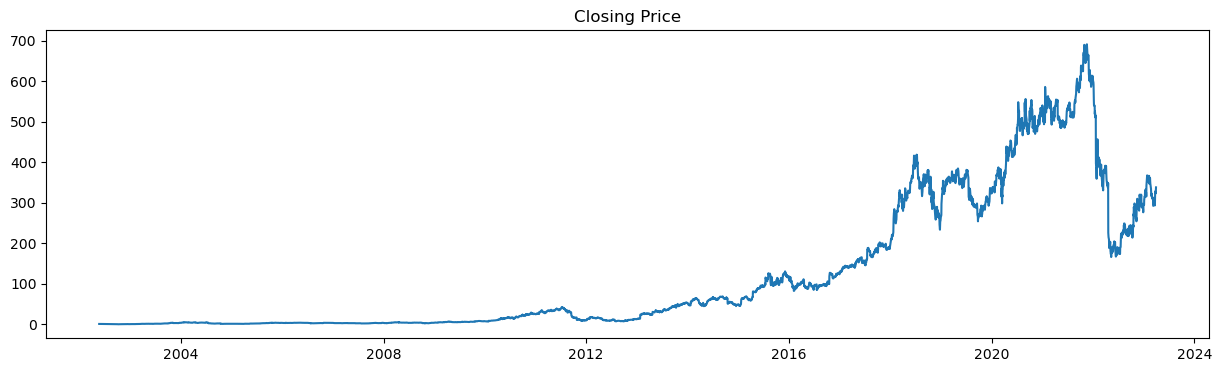

In [34]:
df = df_netflix['Close']
plt.figure(figsize = (15,4))
plt.plot(df)
plt.title("Closing Price")
plt.show()

# Dividing the dataset
Since this is time-series data, we cannot use the scikit-learn train_test_split() function because we need to preserve the order of prices. So, we will use, starting 80% of the values as a training dataset and the rest for testing. We also reshaped the datasets to make them compatible for the next step which is normalization. 

In [35]:
last_index = int(len(df) * 0.8)
train_complete = df[:last_index]

last_index_train = int(len(train_complete) * 0.8)
train = train_complete[:last_index_train].values.reshape(-1, 1)
val = train_complete[last_index_train:].values.reshape(-1, 1)

test = df[last_index:].values.reshape(-1,1)

train.shape, val.shape, test.shape

((3360, 1), (840, 1), (1050, 1))

# Normalization
Normalization converts all the values in the range of 0 to 1. It improves convergence and hence reduces training time.

In [36]:
from sklearn.preprocessing import MinMaxScaler
 
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)
val = scaler.fit_transform(val)
train[:10]

array([[0.00653229],
       [0.00663993],
       [0.00622068],
       [0.00579577],
       [0.00554083],
       [0.00558049],
       [0.00599406],
       [0.00590908],
       [0.00614137],
       [0.00641897]])

# Splitting the dataset into X and Y
This function specifies how many previous values must be considered to find out the pattern, in order to predict a price. Accordingly, both, the training and testing datasets are split into X and Y.

In [37]:
def create_dataset(dataset, time_step=1):
  data_X, data_Y = [], []
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i + time_step), 0]   
    data_X.append(a)
    data_Y.append(dataset[i + time_step, 0])
  return np.array(data_X), np.array(data_Y)

time_step = 10

X_train, y_train = create_dataset(train, time_step)
X_val, y_val = create_dataset(val, time_step)
X_test, y_test = create_dataset(test, time_step)

In [38]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)

In [39]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, LSTM
 
model = Sequential([LSTM(50, input_shape=[10, 1,], return_sequences=True, return_state=False),
                    Dense(1, activation='relu')])
model.compile(loss = 'mean_squared_error', optimizer = 'adam')
model.build()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 50)            10400     
                                                                 
 dense_2 (Dense)             (None, 10, 1)             51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [40]:
histora = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 25)

Epoch 1/25


2023-03-31 12:34:40.655679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 12:34:40.798436: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  5/105 [>.............................] - ETA: 1s - loss: 0.0529  

2023-03-31 12:34:40.916389: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 0.0369

2023-03-31 12:34:42.493781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 12:34:42.550996: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 3s 17ms/step - loss: 0.0369 - val_loss: 0.1208
Epoch 2/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0356 - val_loss: 0.1175
Epoch 3/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0353 - val_loss: 0.1090
Epoch 4/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0353 - val_loss: 0.1120
Epoch 5/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0353 - val_loss: 0.1085
Epoch 6/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0352 - val_loss: 0.1015
Epoch 7/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0353 - val_loss: 0.1159
Epoch 8/25
105/105 [==============================] - 1s 14ms/step - loss: 0.0352 - val_loss: 0.1160
Epoch 9/25
105/105 [==============================] - 2s 17ms/step - loss: 0.0352 - val_loss: 0.1081
Epoch 10/25
105/105 [==============================] - 2s 15ms/step - loss: 0.0352 - val_loss: 0.1164


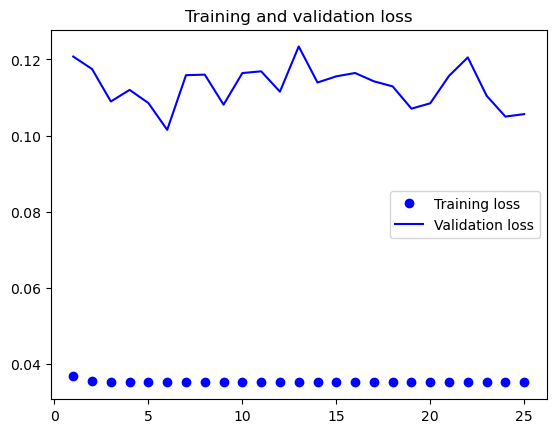

In [41]:
def plot_history(history):
    #acc = history.history['acc']
    #val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    #plt.plot(epochs, acc, 'bo', label='Training acc')
    #plt.plot(epochs, val_acc, 'b', label='Validation acc')
    #plt.title('Training and validation accuracy')
    #plt.legend()
    
    plt.figure()
    
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
plot_history(histora)

In [42]:
test_predict = model.predict(X_test)
test_predict[:10]

10/33 [========>.....................] - ETA: 0s

2023-03-31 12:35:20.476699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-03-31 12:35:20.530679: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


33/33 [==============================] - 0s 6ms/step


array([[[0.22565582],
        [0.22298712],
        [0.2332294 ],
        [0.23957834],
        [0.24387729],
        [0.24581894],
        [0.24621844],
        [0.24739724],
        [0.2477037 ],
        [0.25010416]],

       [[0.2254363 ],
        [0.2230176 ],
        [0.23502758],
        [0.2405661 ],
        [0.24367231],
        [0.2448006 ],
        [0.2464818 ],
        [0.24712184],
        [0.24973875],
        [0.24928412]],

       [[0.22550261],
        [0.22496113],
        [0.23607057],
        [0.24038896],
        [0.24266943],
        [0.24507844],
        [0.24621296],
        [0.24915612],
        [0.2489222 ],
        [0.2503334 ]],

       [[0.22764984],
        [0.22598907],
        [0.23590451],
        [0.23938048],
        [0.24295372],
        [0.24480611],
        [0.24824294],
        [0.24833745],
        [0.24996501],
        [0.25020427]],

       [[0.22847   ],
        [0.22550619],
        [0.234727  ],
        [0.23958164],
        [0.24261951],
  

# Inversing Transformation
Since we normalized the data earlier and converted all the values in the range 0 to 1, now we should inverse the transformation to get actual values. 

In [43]:
test_predict=scaler.inverse_transform(test_predict)

ValueError: Found array with dim 3. None expected <= 2.

# Visualizing the predictions
Here we have plotted actual and predicted stock prices for the test dataset. We can see that the model is performing fine.

In [ ]:
plt.figure(figsize = (15,4))
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)), color = 'r', label = 'actual')
plt.plot(test_predict, color = 'b',label = 'predicted')
plt.legend()
plt.show()

# Evaluating model
For evaluation, we will be using root mean square values.

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test,test_predict, squared = False)